### Imports & Options

In [1]:
%load_ext autoreload
%autoreload 2

In [126]:
import numpy as np
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt

In [81]:
from src.directories import DATA_DIR
from src import rides, graph, utils

### Data

In [92]:
chicago = graph.download_biking_network()
df = rides.load_data()

### Bicycle Trips

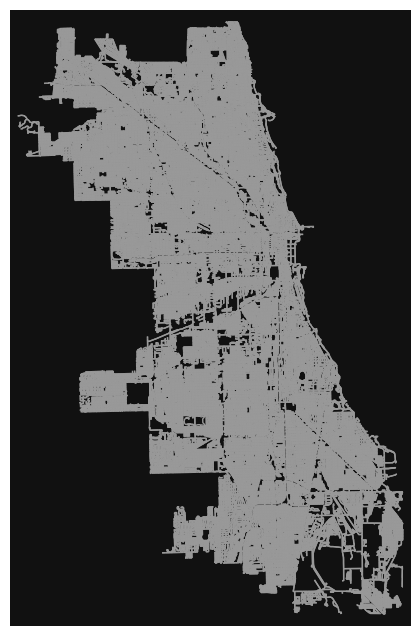

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
ox.plot_graph(chicago, node_size=0)

#### Quick Summary of Rides Table

In [78]:
first = df["started_at"].min().strftime("%A, %B %-d")
last = df["ended_at"].max().strftime("%A, %B %-d")
f"{df.shape[0]:,} trips between {first}, and {last}."

'761,512 trips between Saturday, July 1, and Tuesday, August 1.'

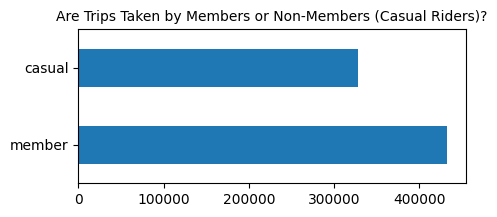

In [79]:
fig, ax = plt.subplots(figsize=(5,2))
df["member_casual"].value_counts().plot.barh(ax=ax)
ax.set_title("Are Trips Taken by Members or Non-Members (Casual Riders)?", fontsize=10)
ax.set_ylabel("");

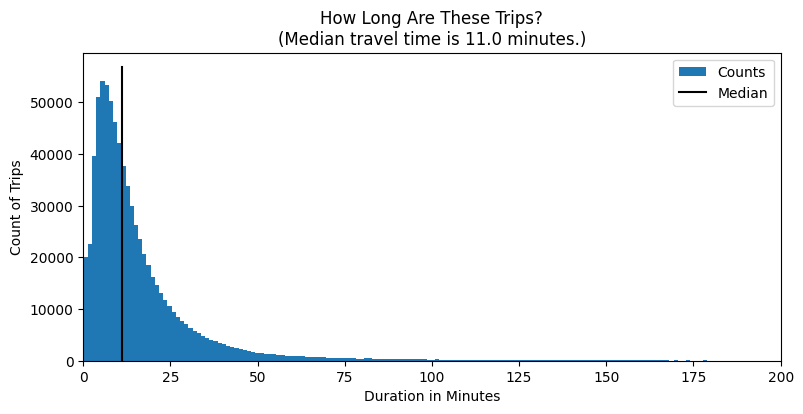

In [80]:
fig, ax = plt.subplots(figsize=(9,4))
ax = df["duration"].apply(lambda td: td.seconds / 60).plot.hist(ax=ax, bins=400, label="Counts")

_median = df["duration"].apply(lambda td: td.seconds / 60).median()
ax.plot([_median, _median], [0, ax.get_ylim()[1]], color="k", label="Median")

ax.set_title(f"How Long Are These Trips?\n(Median travel time is {_median} minutes.)")
ax.set_ylabel("Count of Trips")
ax.set_xlabel("Duration in Minutes")
ax.set_xlim([0,200])
ax.legend()

In [112]:
crow_flies = lambda row: utils.as_the_crow_flies_distance(row.start_lat, row.start_lng, row.end_lat, row.end_lng)
df["distance"] = df.apply(crow_flies, axis=1)

Text(0, 0.5, 'Count of Trips')

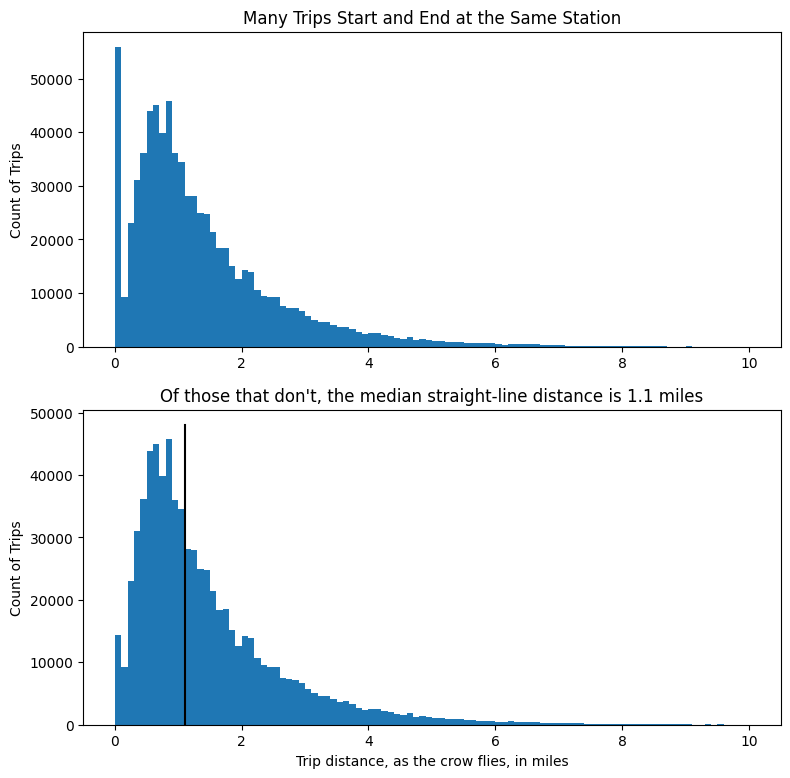

In [147]:
fig, ax = plt.subplots(nrows=2, figsize=(9,9))

chart_df = df[df["distance"] <= 10]

bin_width = 0.1
data = chart_df["distance"].values
bins = np.arange(min(data), max(data) + bin_width, bin_width)
chart_df["distance"].plot.hist(ax=ax[0], bins=bins)
ax[0].set_title("Many Trips Start and End at the Same Station")
ax[0].set_ylabel("Count of Trips")

chart_df = chart_df[chart_df["distance"] > 0]
chart_df["distance"].plot.hist(ax=ax[1], bins=bins)
_median = df[df["distance"] > 0]["distance"].median()
ax[1].plot([_median, _median], [0, ax[1].get_ylim()[1]], color="k")
_median = round(_median, 1)
ax[1].set_title(f"Of those that don't, the median straight-line distance is {_median} miles")
ax[1].set_xlabel("Trip distance, as the crow flies, in miles")
ax[1].set_ylabel("Count of Trips")